In [22]:
# Import packages
import os
import pandas as pd
import geopandas as gpd
import ee
import geemap
import matplotlib.pyplot as plt
import pymannkendall as mk

In [2]:

# Open shp Ecuador
ecuador_shp_path = r"C:\Users\Francesco\Python\earthlab\Ecuador\data\ec_shp\ec.shp"
ecuador_gdf = gpd.read_file(ecuador_shp_path)

# Find Bolivar Province
print('Ecuador shp columns:', ecuador_gdf.columns)
print('Ecuador shp first rows:')
ecuador_gdf.head()

Ecuador shp columns: Index(['id', 'name', 'source', 'geometry'], dtype='object')
Ecuador shp first rows:


,id,name,source,geometry
0,ECE,Esmeraldas,https://simplemaps.com,"MULTIPOLYGON (((-78.47812 1.18712, -78.47831 1..."
1,ECC,Carchi,https://simplemaps.com,"POLYGON ((-78.44211 0.87194, -78.44714 0.87437..."
2,ECU,Sucumbios,https://simplemaps.com,"POLYGON ((-77.81408 0.34566, -77.79186 0.37099..."
3,ECD,Orellana,https://simplemaps.com,"POLYGON ((-77.29941 -0.05855, -77.28401 -0.047..."
4,ECY,Pastaza,https://simplemaps.com,"POLYGON ((-77.05165 -1.01038, -77.07198 -1.033..."


Bolivar geometry count: 1


<Axes: >

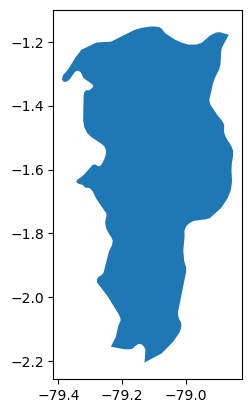

In [3]:
# Get the Bolivar province shp
bolivar_gdf = ecuador_gdf[ecuador_gdf['name'].str.contains('Bolivar', case=False, na=False)]
print('Bolivar geometry count:', len(bolivar_gdf))
bolivar_gdf.plot()

In [ ]:
# Save Bolivar shp
folder_path = r'C:\Users\Francesco\Python\earthlab\Ecuador\data\Bolivar'
os.makedirs(folder_path, exist_ok=True)
out_path = os.path.join(folder_path, 'bolivar.shp')
bolivar_gdf.to_file(out_path)
print('Saved bolivar.shp:', out_path)

Saved bolivar.shp: C:\Users\Francesco\Python\earthlab\Ecuador\data\Bolivar\bolivar.shp


In [ ]:
# GEE initialization
try:
    ee.Initialize()
    print('GEE initialized')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()
    print('GEE authenticated and initialized')

In [16]:
# Get the bolivar shp for GEE
bolivar = geemap.shp_to_ee(out_path)

# Time frame (2024)
start_date = '2024-01-01'
end_date = '2024-12-31'

# Mask function
def mask_landsat_clouds(image):
    
    qa = image.select('QA_PIXEL')

    # Bits for cloud and shadow
    cloud_shadow_bit = 1 << 3
    snow_bit = 1 << 4
    cloud_bit = 1 << 5
    cirrus_bit = 1 << 7

    # Set bits to 0 (clear)
    mask = (qa.bitwiseAnd(cloud_shadow_bit).eq(0)
            .And(qa.bitwiseAnd(snow_bit).eq(0))
            .And(qa.bitwiseAnd(cloud_bit).eq(0))
            .And(qa.bitwiseAnd(cirrus_bit).eq(0)))
    
    # Apply mask
    image = image.updateMask(mask)

    # Scale values to reflectance values (multiply by 0.0000275 and add -0.2)
    image = image.multiply(0.0000275).add(-0.2)

    return image

# Load masked landsat images
landsat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
           .filterBounds(bolivar)
           .filterDate(start_date, end_date)
           .map(mask_landsat_clouds))

# NDVI function
def add_ndvi(image, nir, red):
    
    ndvi = image.normalizedDifference([nir, red]).rename('NDVI')

    return image.addBands(ndvi)

# Create landsat images with NDVI
nir_landsat = 'SR_B5'
red_landsat = 'SR_B4'
landsat_ndvi = landsat.map(lambda img: add_ndvi(img, nir_landsat, red_landsat))

# Get the pixel median ndvi over each image (time)
median_ndvi = landsat_ndvi.select('NDVI').median().clip(bolivar)

# Visualize the median NDVI
# Create a new map instance
Map = geemap.Map()
# Center the map on bolivar with a zoom level 8
Map.centerObject(bolivar, 9)
# Map the median ndvi with a palette color
Map.addLayer(median_ndvi, {'min': 0,
                           'max': 1,
                           'palette': ['brown', 'yellow', 'green']},
                           'median NDVI')
# Map bolivar boundary
Map.addLayer(bolivar, {}, 'Bolivar Province boundary')
# Map it
Map

Map(center=[-1.6002981943034977, -79.10426538801437], controls=(WidgetControl(options=['position', 'transparen…

In [19]:
# NDVI TIME SERIES

start_year = 2013
end_year = 2024

years = list(range(start_year, end_year + 1))

def yearly_ndvi(year):

    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    coll = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterBounds(bolivar)
            .filterDate(start, end)
            .map(mask_landsat_clouds)
            .map(lambda img: add_ndvi(img, nir_landsat, red_landsat)))
    
    # Median on each pixel of the NDVI of each image in the time period
    median_ndvi_coll = coll.select('NDVI').median().clip(bolivar)

    # Mean of the median ndvi image
    mean_ndvi_dict = median_ndvi_coll.reduceRegion(reducer = ee.Reducer.mean(),
                                                   geometry = bolivar.geometry(),
                                                   scale = 30,
                                                   bestEffort = True)
    
    return {'year': year,
            'mean_NDVI': mean_ndvi_dict.get('NDVI').getInfo()}

# Build list of results
results = []
for y in years:
    results.append(yearly_ndvi(y))

# Convert the list into a dataframe
yearly_ndvi_df = pd.DataFrame(results)
print(yearly_ndvi_df)

    year  mean_NDVI
0   2013   0.553262
1   2014   0.627839
2   2015   0.511862
3   2016   0.552019
4   2017   0.587980
5   2018   0.565849
6   2019   0.559647
7   2020   0.516169
8   2021   0.535887
9   2022   0.550406
10  2023   0.547876
11  2024   0.542209


In [21]:
# Export yearly ndvi as a csv
yearly_ndvi_df.to_csv(rf"C:\Users\Francesco\Python\earthlab\Ecuador\data\Bolivar\yearly_mean_ndvi_bolivar_{start_year}_{end_year}.csv")
print(rf'NDVI time series saved: C:\Users\Francesco\Python\earthlab\Ecuador\data\Bolivar\yearly_mean_ndvi_bolivar_{start_year}_{end_year}.csv')

NDVI time series saved: C:\Users\Francesco\Python\earthlab\Ecuador\data\Bolivar\yearly_mean_ndvi_bolivar_2013_2024.csv


In [25]:
# Perform the Mann-Kendall Test on the time series

time_series_ndvi_df = pd.read_csv(r"C:\Users\Francesco\Python\earthlab\Ecuador\data\Bolivar\yearly_mean_ndvi_bolivar_2013_2024.csv")
time_series_ndvi_df = time_series_ndvi_df.sort_values('year')

mann_kendall_results = mk.original_test(time_series_ndvi_df['mean_NDVI'])

print('Mann-Kendall Test Results:\n')
print(mann_kendall_results)

Mann-Kendall Test Results:

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.19261627432960227), z=np.float64(-1.302878414515109), Tau=np.float64(-0.30303030303030304), s=np.float64(-20.0), var_s=212.66666666666666, slope=np.float64(-0.0030115705159233187), intercept=np.float64(0.5677761986229203))


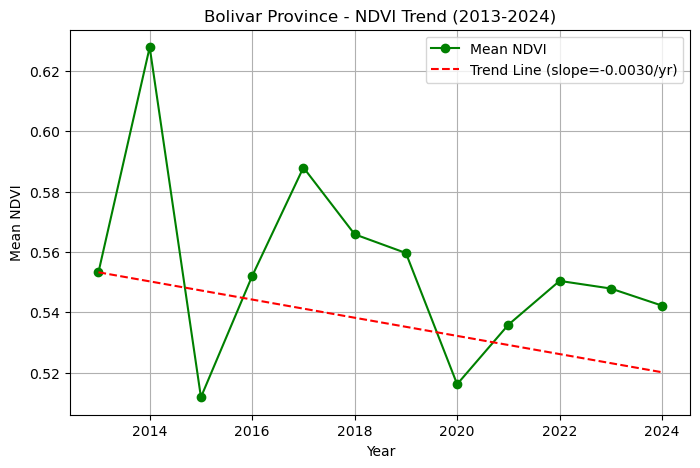

In [26]:
# Extract Sen's slope (trend magnitude)
slope = mann_kendall_results.slope
intercept = time_series_ndvi_df['mean_NDVI'].iloc[0] - slope * time_series_ndvi_df['year'].iloc[0]

# Compute the trend line
time_series_ndvi_df['trend_line'] = intercept + slope * time_series_ndvi_df['year']

# Plot NDVI and trend line
plt.figure(figsize=(8, 5))
plt.plot(time_series_ndvi_df['year'], time_series_ndvi_df['mean_NDVI'], 'o-', label='Mean NDVI', color='green')
plt.plot(time_series_ndvi_df['year'], time_series_ndvi_df['trend_line'], 'r--', label=f'Trend Line (slope={slope:.4f}/yr)')
plt.title('Bolivar Province - NDVI Trend (2013-2024)')
plt.xlabel('Year')
plt.ylabel('Mean NDVI')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Pixel-wise NDVI Trend Mapping

# Built a list of median NDVI images
ndvi_images = []

for year in years:
    
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    coll = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterBounds(bolivar)
            .filterDate(start, end)
            .map(mask_landsat_clouds)
            .map(lambda img: add_ndvi(img, nir_landsat, red_landsat)))
    
    median_ndvi = coll.select('NDVI').median().clip(bolivar).set('year', year)
    ndvi_images.append(median_ndvi)

# Create an Image Collection form the list of images
ndvi_coll = ee.ImageCollection(ndvi_images)

# Add the time band to each image
def add_time_band(img):
    year = ee.Number(img.get('year'))
    return img.addBands(ee.Image.constant(year).rename('year')).float()

ndvi_with_time = ndvi_coll.map(add_time_band)

# Perform the linear regression on the NDVI for each image(year)
trend = ndvi_with_time.select(['year', 'NDVI']).reduce(ee.Reducer.linearFit())

# Get the slope and the intercepts
slope = trend.select('scale').clip(bolivar)
intercept = trend.select('offset').clip(bolivar)

# Visualize
Map = geemap.Map()
Map.centerObject(bolivar, 9)
Map.addLayer(slope, {'min': -0.01,
                     'max': 0.01,
                     'palette': ['red', 'white', 'green']}, 'NDVI Trend (Slope per Year)')

Map.addLayer(bolivar, {}, 'Bolivar Province Boundary')
Map

Map(center=[-1.6002981943034977, -79.10426538801437], controls=(WidgetControl(options=['position', 'transparen…